<a href="https://colab.research.google.com/github/Tejaasree/Tejasree_AdvancedMachineLearning/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-05 02:45:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.24.152, 52.217.159.40, 54.231.236.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.24.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  60.6MB/s    in 0.2s    

2025-04-05 02:45:36 (60.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


# Loading and inspecting the jena climate dataset

In [15]:
import os

file_name = os.path.join("jena_climate_2009_2016.csv")
with open(file_name) as file:
    content = file.read()

line_list = content.split("\n")
header_columns = line_list[0].split(",")
line_list = line_list[1:]

print(header_columns)
print(f"Number of data lines: {len(line_list)}")

variable_count = len(header_columns)
print(f"Total variables: {variable_count}")
row_count = len(line_list)
print(f"Total data rows: {row_count}")


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of data lines: 420451
Total variables: 15
Total data rows: 420451


In [16]:
import numpy as np

temp_values = np.zeros((len(lines),))
dataset = np.zeros((len(lines), len(header) - 1))

for index, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp_values[index] = values[1]
    dataset[index, :] = values[:]


# Plotting the Temparature Data

Text(0, 0.5, 'Temperature')

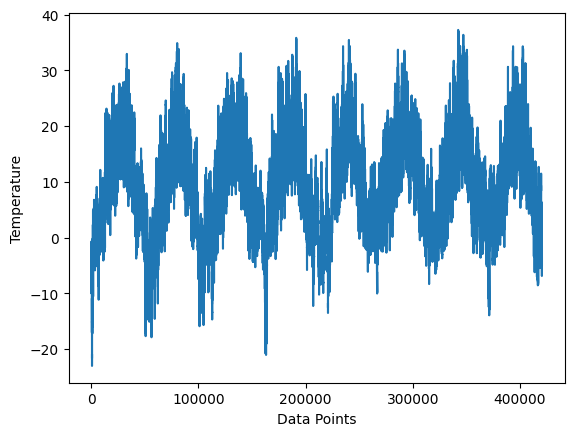

In [18]:

from matplotlib import pyplot as plt

plt.plot(range(len(temp_values)), temp_values)

plt.xlabel('Data Points')
plt.ylabel('Temperature')



# # Plotting the First 1440 Data Points of Temperature

Text(0, 0.5, 'Temperature')

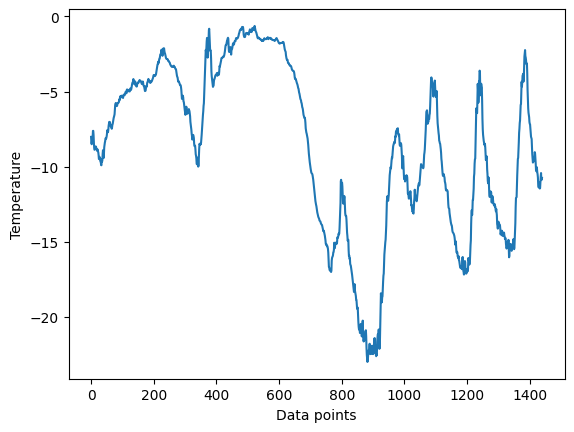

In [7]:

plt.plot(range(1440), temperature[:1440])

plt.xlabel('Data Points')
plt.ylabel('Temperature')


# Split the data into Training, Validation, and Test Sets

In [19]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Normalization of the dataset

In [9]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [11]:
import numpy as np
from tensorflow import keras

# Create a simple sequence
int_sequence = np.arange(10)

# Create a timeseries dataset
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

# Print the data in the dataset
for inputs, targets in dummy_dataset:
    print("Inputs:", inputs.numpy())
    print("Targets:", targets.numpy())


Inputs: [[0 1 2]
 [1 2 3]]
Targets: [3 4]
Inputs: [[2 3 4]
 [3 4 5]]
Targets: [5 6]
Inputs: [[4 5 6]]
Targets: [7]


# Because of extremely redundant samples, datasets for training, validation, and testing must be created.  Creating samples dynamically is more economical than explicitly allocating RAM for each one.

In [20]:

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [21]:

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (256, 120, 14)
targets shape: (256,)


# Using Naive Method to evaluate on Validation and Test Datasets

In [22]:

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


## A Simple Machine Learning Model
 Training a Densely Connected Model with Dense Layers


In [23]:


from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]


In [25]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset, callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 39s 46ms/step - loss: 11.7600 - mae: 2.6677 - val_loss: 11.0277 - val_mae: 2.6082
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 8.9924 - mae: 2.3609 - val_loss: 10.2216 - val_mae: 2.5111
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.2312 - mae: 2.2587 - val_loss: 10.3483 - val_mae: 2.5376
Epoch 4/10
819/819 [==============================] - 37s 45ms/step - loss: 7.7807 - mae: 2.1965 - val_loss: 10.4877 - val_mae: 2.5588
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 7.4456 - mae: 2.1481 - val_loss: 10.5028 - val_mae: 2.5491
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 7.2002 - mae: 2.1114 - val_loss: 10.5866 - val_mae: 2.5556
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 7.0036 - mae: 2.0838 - val_loss: 10.9655 - val_mae: 2.6026
Epoch 8/10
819/819 [==============================] - 

In [27]:
trained_model = keras.models.load_model("jena_dense.keras")
test_loss, test_mae = trained_model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")


405/405 [==============================] - 13s 31ms/step - loss: 11.5259 - mae: 2.6621
Test MAE: 2.66


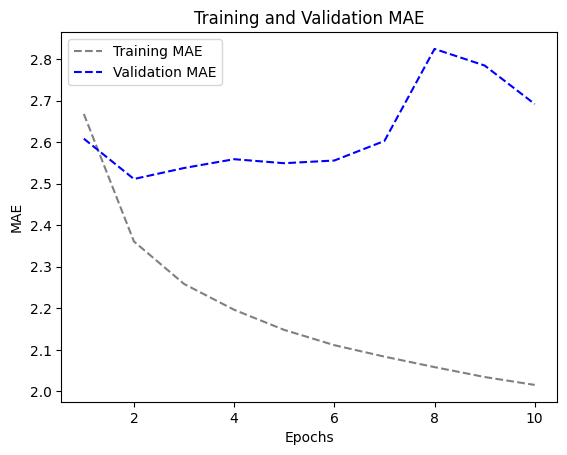

In [28]:
import matplotlib.pyplot as plt
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

epochs = range(1, len(train_mae) + 1)
plt.figure()
plt.plot(epochs, train_mae, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_mae, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


# 1D convolutional model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
conv_model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv_model.keras",
                                    save_best_only=True)
]

conv_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
train_history = conv_model.fit(train_dataset,
                               epochs=10,
                               validation_data=val_dataset,
                               callbacks=callbacks)

conv_model = keras.models.load_model("jena_conv_model.keras")
test_mae = conv_model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 76s 91ms/step - loss: 21.2280 - mae: 3.6357 - val_loss: 15.7119 - val_mae: 3.1604
Epoch 2/10
819/819 [==============================] - 73s 89ms/step - loss: 15.8685 - mae: 3.1692 - val_loss: 15.5528 - val_mae: 3.1152
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 14.5882 - mae: 3.0308 - val_loss: 16.5856 - val_mae: 3.2163
Epoch 4/10
819/819 [==============================] - 74s 90ms/step - loss: 13.7942 - mae: 2.9467 - val_loss: 14.6970 - val_mae: 3.0323
Epoch 5/10
819/819 [==============================] - 77s 94ms/step - loss: 13.2162 - mae: 2.8806 - val_loss: 14.3100 - val_mae: 2.9816
Epoch 6/10
819/819 [==============================] - 73s 89ms/step - loss: 12.7732 - mae: 2.8303 - val_loss: 14.8865 - val_mae: 3.0267
Epoch 7/10
819/819 [==============================] - 74s 90ms/step - loss: 12.3294 - mae: 2.7770 - val_loss: 19.8827 - val_mae: 3.5551
Epoch 8/10
819/819 [============================

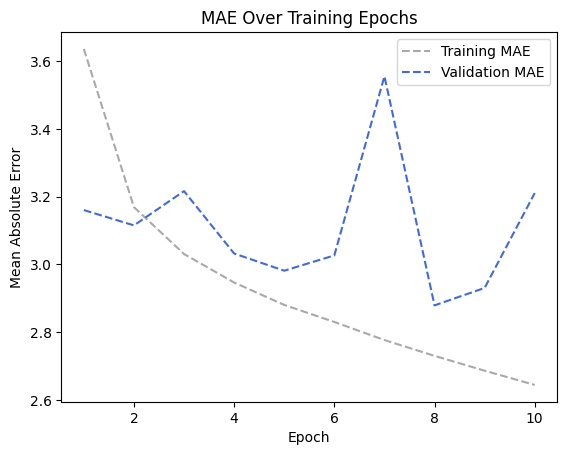

In [30]:
import matplotlib.pyplot as plt

train_mae = train_history.history["mae"]
val_mae = train_history.history["val_mae"]

epoch_range = range(1, len(train_mae) + 1)
plt.figure()
plt.plot(epoch_range, train_mae, color="darkgray", linestyle="dashed", label="Training MAE")
plt.plot(epoch_range, val_mae, color="royalblue", linestyle="dashed", label="Validation MAE")
plt.title("MAE Over Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


A Simple RNN
 1. An RNN layer capable of handling any length of sequence


In [31]:

num_attributes = 14
rnn_input = keras.Input(shape=(None, num_attributes))
rnn_output = layers.SimpleRNN(16)(rnn_input)

rnn_model = keras.Model(rnn_input, rnn_output)

rnn_callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN.keras", save_best_only=True)
]

rnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

rnn_history = rnn_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=rnn_callbacks
)

rnn_model = keras.models.load_model("jena_SimpleRNN.keras")
print(f"Test MAE: {rnn_model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 59s 70ms/step - loss: 138.7691 - mae: 9.6853 - val_loss: 144.0174 - val_mae: 9.8998
Epoch 2/10
819/819 [==============================] - 57s 69ms/step - loss: 136.4728 - mae: 9.5676 - val_loss: 143.7852 - val_mae: 9.8775
Epoch 3/10
819/819 [==============================] - 63s 77ms/step - loss: 136.2807 - mae: 9.5524 - val_loss: 143.7764 - val_mae: 9.8768
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 136.2122 - mae: 9.5469 - val_loss: 143.6462 - val_mae: 9.8619
Epoch 5/10
819/819 [==============================] - 56s 68ms/step - loss: 136.1657 - mae: 9.5429 - val_loss: 143.6396 - val_mae: 9.8626
Epoch 6/10
819/819 [==============================] - 56s 68ms/step - loss: 136.1559 - mae: 9.5389 - val_loss: 143.5580 - val_mae: 9.8505
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 136.1321 - mae: 9.5349 - val_loss: 143.5320 - val_mae: 9.8492
Epoch 8/10
819/819 [==============

# Simple GRU(Gated Recurrent Unit)-Based Forecasting Model

In [32]:

gru_input = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
gru_output = layers.GRU(16)(gru_input)
final_prediction = layers.Dense(1)(gru_output)

gru_model = keras.Model(gru_input, final_prediction)
++++
gru_callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_revised.keras", save_best_only=True)
]

gru_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

gru_history = gru_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=gru_callbacks
)

gru_model = keras.models.load_model("jena_gru_revised.keras")
print(f"Test MAE: {gru_model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 89s 107ms/step - loss: 46.6345 - mae: 4.9659 - val_loss: 14.7772 - val_mae: 2.8809
Epoch 2/10
819/819 [==============================] - 88s 107ms/step - loss: 11.0741 - mae: 2.5807 - val_loss: 10.2557 - val_mae: 2.4598
Epoch 3/10
819/819 [==============================] - 93s 113ms/step - loss: 9.8941 - mae: 2.4538 - val_loss: 9.7186 - val_mae: 2.3971
Epoch 4/10
819/819 [==============================] - 88s 107ms/step - loss: 9.6009 - mae: 2.4153 - val_loss: 10.4599 - val_mae: 2.4550
Epoch 5/10
819/819 [==============================] - 89s 108ms/step - loss: 9.3397 - mae: 2.3831 - val_loss: 10.3195 - val_mae: 2.4421
Epoch 6/10
819/819 [==============================] - 89s 109ms/step - loss: 9.0443 - mae: 2.3472 - val_loss: 10.5758 - val_mae: 2.4585
Epoch 7/10
819/819 [==============================] - 90s 109ms/step - loss: 8.8426 - mae: 2.3226 - val_loss: 10.5224 - val_mae: 2.4505
Epoch 8/10
819/819 [===========================

#  Using MAE to Visualize Training and Validation Across Epochs

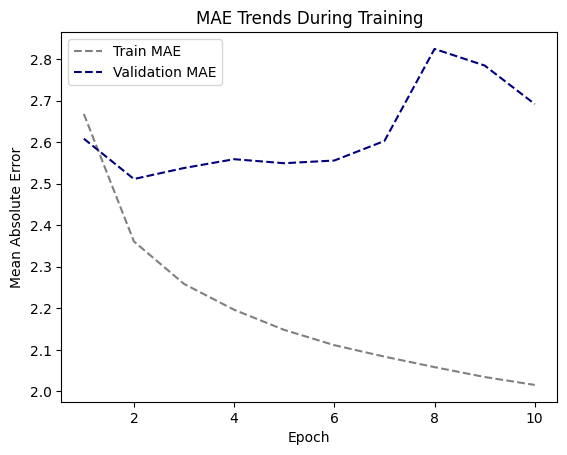

In [33]:


import matplotlib.pyplot as plt

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

epoch_range = range(1, len(train_mae) + 1)

plt.figure()
plt.plot(epoch_range, train_mae, linestyle="dashed", color="gray", label="Train MAE")
plt.plot(epoch_range, val_mae, linestyle="dashed", color="navy", label="Validation MAE")
plt.title("MAE Trends During Training")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


# 1) Weather Forecasting Model Based on LSTM (Simple Variant)

In [34]:

from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_out = layers.LSTM(16)(input_layer)
final_output = layers.Dense(1)(lstm_out)

lstm_model = keras.Model(inputs=input_layer, outputs=final_output)

model_callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = lstm_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=model_callbacks
)

lstm_model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {lstm_model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 91s 109ms/step - loss: 43.5690 - mae: 4.8067 - val_loss: 13.0324 - val_mae: 2.7253
Epoch 2/10
819/819 [==============================] - 89s 108ms/step - loss: 11.1094 - mae: 2.5868 - val_loss: 9.9978 - val_mae: 2.4557
Epoch 3/10
819/819 [==============================] - 88s 107ms/step - loss: 9.8949 - mae: 2.4544 - val_loss: 10.2412 - val_mae: 2.4555
Epoch 4/10
819/819 [==============================] - 85s 103ms/step - loss: 9.4806 - mae: 2.4038 - val_loss: 10.1890 - val_mae: 2.4511
Epoch 5/10
819/819 [==============================] - 91s 110ms/step - loss: 9.1455 - mae: 2.3616 - val_loss: 10.4434 - val_mae: 2.4868
Epoch 6/10
819/819 [==============================] - 90s 109ms/step - loss: 8.7237 - mae: 2.3115 - val_loss: 10.3291 - val_mae: 2.4823
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 8.4383 - mae: 2.2724 - val_loss: 10.3054 - val_mae: 2.4898
Epoch 8/10
819/819 [===========================

#  Comparing Training and Validation MAE Visualization

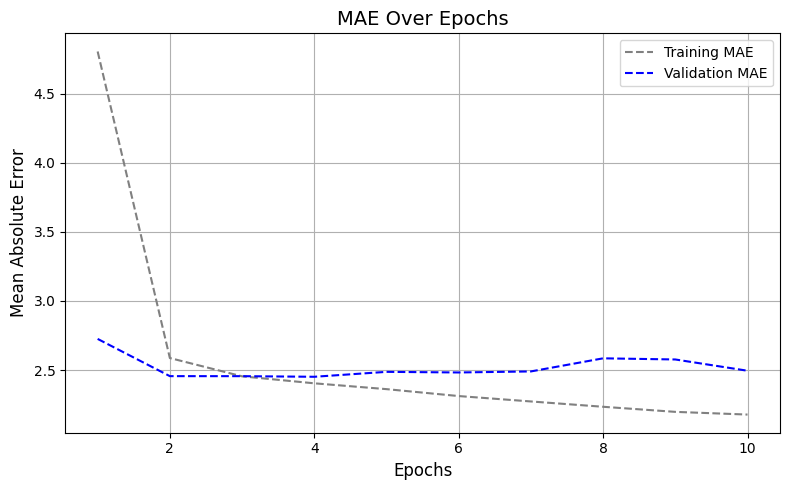

In [35]:

import matplotlib.pyplot as plt

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]
epoch_range = range(1, len(train_mae) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epoch_range, train_mae, linestyle="--", color="gray", label="Training MAE")
plt.plot(epoch_range, val_mae, linestyle="--", color="blue", label="Validation MAE")
plt.title("MAE Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2)Implementing dropout regularization in the LSTM model definition

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_layer = layers.LSTM(16, recurrent_dropout=0.25)(input_layer)
dropout_layer = layers.Dropout(0.5)(lstm_layer)
output_layer = layers.Dense(1)(dropout_layer)
model = keras.Model(inputs=input_layer, outputs=output_layer)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 142s 170ms/step - loss: 48.4423 - mae: 5.1821 - val_loss: 13.4173 - val_mae: 2.7666
Epoch 2/10
819/819 [==============================] - 139s 169ms/step - loss: 20.1722 - mae: 3.4476 - val_loss: 9.8401 - val_mae: 2.4416
Epoch 3/10
819/819 [==============================] - 139s 170ms/step - loss: 18.1262 - mae: 3.2763 - val_loss: 9.9156 - val_mae: 2.4568
Epoch 4/10
819/819 [==============================] - 138s 168ms/step - loss: 17.2891 - mae: 3.2031 - val_loss: 9.5551 - val_mae: 2.4100
Epoch 5/10
819/819 [==============================] - 138s 168ms/step - loss: 16.5836 - mae: 3.1363 - val_loss: 9.4817 - val_mae: 2.3962
Epoch 6/10
819/819 [==============================] - 136s 166ms/step - loss: 15.9493 - mae: 3.0794 - val_loss: 9.2660 - val_mae: 2.3662
Epoch 7/10
819/819 [==============================] - 136s 166ms/step - loss: 15.4179 - mae: 3.0269 - val_loss: 9.4775 - val_mae: 2.3986
Epoch 8/10
819/819 [====================

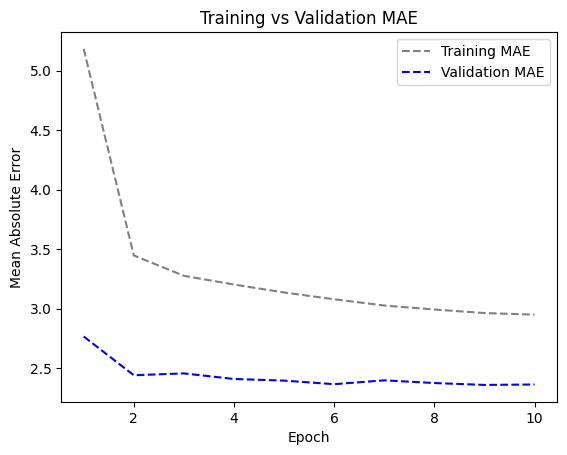

In [37]:
import matplotlib.pyplot as plt

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

epoch_range = range(1, len(train_mae) + 1)
plt.figure()
plt.plot(epoch_range, train_mae, linestyle="dashed", color="grey", label="Training MAE")
plt.plot(epoch_range, val_mae, linestyle="dashed", color="blue", label="Validation MAE")
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


# 3)Implementing dropout regularization in the LSTM model definition



In [38]:
from tensorflow import keras
from tensorflow.keras import layers

input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_out = layers.LSTM(16, return_sequences=True)(input_layer)
lstm_out = layers.LSTM(16)(lstm_out)
final_output = layers.Dense(1)(lstm_out)

model = keras.Model(input_layer, final_output)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 152s 181ms/step - loss: 35.0749 - mae: 4.3104 - val_loss: 11.9298 - val_mae: 2.6442
Epoch 2/10
819/819 [==============================] - 148s 180ms/step - loss: 10.1062 - mae: 2.4756 - val_loss: 10.1021 - val_mae: 2.4830
Epoch 3/10
819/819 [==============================] - 144s 175ms/step - loss: 8.8632 - mae: 2.3302 - val_loss: 10.1888 - val_mae: 2.4610
Epoch 4/10
819/819 [==============================] - 146s 178ms/step - loss: 8.1260 - mae: 2.2324 - val_loss: 11.1643 - val_mae: 2.5963
Epoch 5/10
819/819 [==============================] - 143s 175ms/step - loss: 7.5157 - mae: 2.1468 - val_loss: 10.9523 - val_mae: 2.5597
Epoch 6/10
819/819 [==============================] - 147s 179ms/step - loss: 7.1268 - mae: 2.0855 - val_loss: 11.3259 - val_mae: 2.6079
Epoch 7/10
819/819 [==============================] - 149s 181ms/step - loss: 6.7092 - mae: 2.0259 - val_loss: 11.7375 - val_mae: 2.6825
Epoch 8/10
819/819 [===================

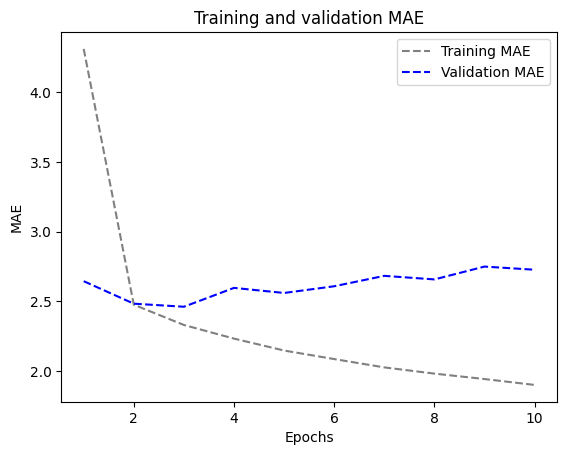

In [39]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


#4)32-unit LSTM stacked configuration

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 222s 266ms/step - loss: 21.8000 - mae: 3.3354 - val_loss: 11.3831 - val_mae: 2.6227
Epoch 2/10
819/819 [==============================] - 260s 317ms/step - loss: 8.6256 - mae: 2.2852 - val_loss: 10.9907 - val_mae: 2.6210
Epoch 3/10
819/819 [==============================] - 218s 266ms/step - loss: 7.3192 - mae: 2.1068 - val_loss: 10.6014 - val_mae: 2.5613
Epoch 4/10
819/819 [==============================] - 211s 258ms/step - loss: 6.3496 - mae: 1.9587 - val_loss: 11.5484 - val_mae: 2.6723
Epoch 5/10
819/819 [==============================] - 211s 257ms/step - loss: 5.5186 - mae: 1.8213 - val_loss: 11.7567 - val_mae: 2.7149
Epoch 6/10
819/819 [==============================] - 211s 257ms/step - loss: 4.8414 - mae: 1.6998 - val_loss: 11.7850 - val_mae: 2.6971
Epoch 7/10
819/819 [==============================] - 216s 263ms/step - loss: 4.3529 - mae: 1.6088 - val_loss: 12.6021 - val_mae: 2.7976
Epoch 8/10
819/819 [====================

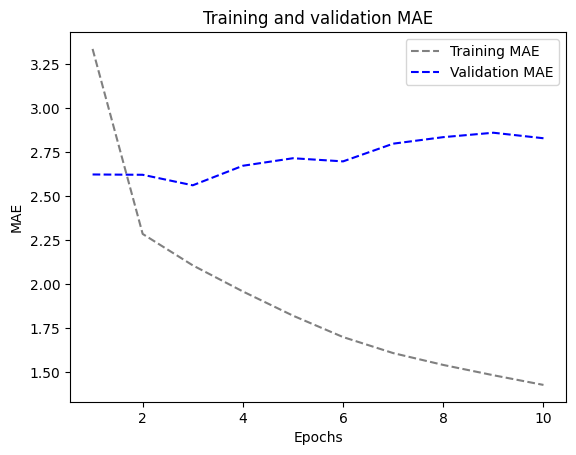

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


## 4.LSTM: Eight units in a stacked configuration



In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 149s 175ms/step - loss: 62.8721 - mae: 6.0103 - val_loss: 29.8286 - val_mae: 4.0509
Epoch 2/10
819/819 [==============================] - 122s 149ms/step - loss: 18.6538 - mae: 3.2166 - val_loss: 12.3282 - val_mae: 2.6659
Epoch 3/10
819/819 [==============================] - 122s 148ms/step - loss: 10.9183 - mae: 2.5651 - val_loss: 9.9808 - val_mae: 2.4532
Epoch 4/10
819/819 [==============================] - 137s 167ms/step - loss: 9.8589 - mae: 2.4430 - val_loss: 9.8092 - val_mae: 2.4327
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 9.4959 - mae: 2.3952 - val_loss: 9.8979 - val_mae: 2.4579
Epoch 6/10
819/819 [==============================] - 121s 147ms/step - loss: 9.2992 - mae: 2.3688 - val_loss: 10.1846 - val_mae: 2.5007
Epoch 7/10
819/819 [==============================] - 119s 145ms/step - loss: 9.1286 - mae: 2.3491 - val_loss: 9.9757 - val_mae: 2.4679
Epoch 8/10
819/819 [======================

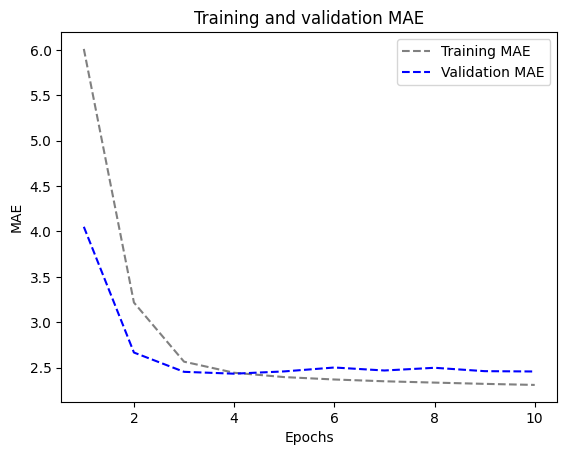

In [43]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


# 5.LSTM: stacked, dropout-regularized model

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 233s 278ms/step - loss: 80.6144 - mae: 6.9262 - val_loss: 39.6168 - val_mae: 4.6831
Epoch 2/10
819/819 [==============================] - 226s 276ms/step - loss: 33.6996 - mae: 4.3223 - val_loss: 15.1408 - val_mae: 2.9103
Epoch 3/10
819/819 [==============================] - 224s 273ms/step - loss: 24.7884 - mae: 3.7610 - val_loss: 11.3518 - val_mae: 2.5805
Epoch 4/10
819/819 [==============================] - 222s 271ms/step - loss: 22.7452 - mae: 3.6127 - val_loss: 10.6543 - val_mae: 2.5217
Epoch 5/10
819/819 [==============================] - 222s 271ms/step - loss: 21.3253 - mae: 3.5019 - val_loss: 10.3918 - val_mae: 2.4992
Epoch 6/10
819/819 [==============================] - 223s 272ms/step - loss: 20.4405 - mae: 3.4336 - val_loss: 9.8008 - val_mae: 2.4340
Epoch 7/10
819/819 [==============================] - 223s 272ms/step - loss: 19.4473 - mae: 3.3523 - val_loss: 10.9866 - val_mae: 2.5522
Epoch 8/10
819/819 [===============

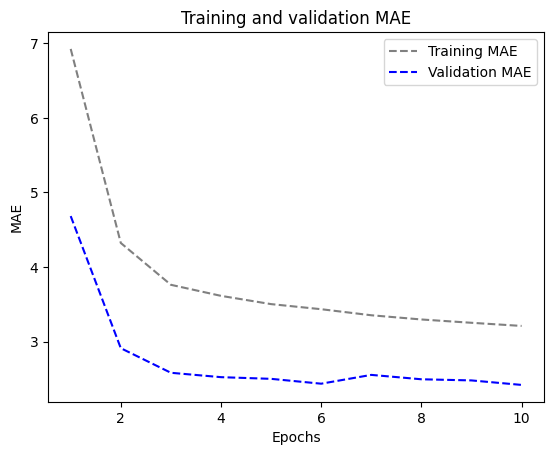

In [45]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


# Bidirectional LSTM model

In [51]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 145s 170ms/step - loss: 26.3385 - mae: 3.6835 - val_loss: 10.5120 - val_mae: 2.5064
Epoch 2/10
819/819 [==============================] - 150s 183ms/step - loss: 9.2395 - mae: 2.3707 - val_loss: 10.1170 - val_mae: 2.4501
Epoch 3/10
819/819 [==============================] - 137s 167ms/step - loss: 8.2708 - mae: 2.2348 - val_loss: 10.2597 - val_mae: 2.4683
Epoch 4/10
819/819 [==============================] - 137s 167ms/step - loss: 7.7490 - mae: 2.1645 - val_loss: 10.3628 - val_mae: 2.4941
Epoch 5/10
819/819 [==============================] - 135s 165ms/step - loss: 7.3933 - mae: 2.1171 - val_loss: 10.6053 - val_mae: 2.5292
Epoch 6/10
819/819 [==============================] - 134s 163ms/step - loss: 7.1202 - mae: 2.0816 - val_loss: 10.2853 - val_mae: 2.4932
Epoch 7/10
819/819 [==============================] - 134s 164ms/step - loss: 6.8830 - mae: 2.0482 - val_loss: 10.5008 - val_mae: 2.5256
Epoch 8/10
819/819 [====================

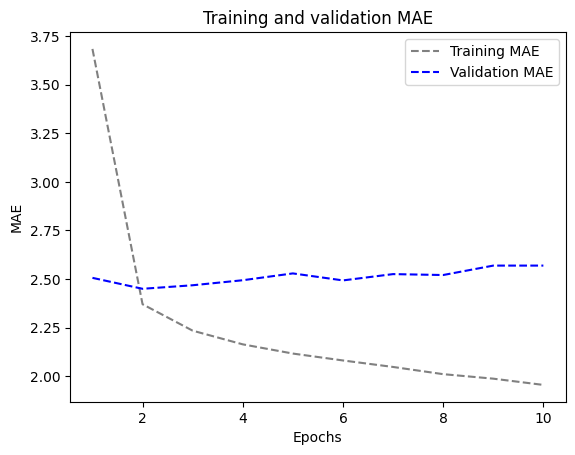

In [52]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


# combining 1D Convolutional Networks (Conv1D) with LSTM layers

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 106s 124ms/step - loss: 48.5553 - mae: 5.2119 - val_loss: 25.3878 - val_mae: 3.9035
Epoch 2/10
819/819 [==============================] - 99s 120ms/step - loss: 17.8188 - mae: 3.2683 - val_loss: 21.0572 - val_mae: 3.6218
Epoch 3/10
819/819 [==============================] - 98s 119ms/step - loss: 14.7705 - mae: 2.9880 - val_loss: 22.1986 - val_mae: 3.6977
Epoch 4/10
819/819 [==============================] - 99s 120ms/step - loss: 13.0422 - mae: 2.8023 - val_loss: 22.9818 - val_mae: 3.7545
Epoch 5/10
819/819 [==============================] - 100s 121ms/step - loss: 11.7727 - mae: 2.6547 - val_loss: 22.9659 - val_mae: 3.8071
Epoch 6/10
819/819 [==============================] - 100s 122ms/step - loss: 10.8887 - mae: 2.5465 - val_loss: 23.2072 - val_mae: 3.7926
Epoch 7/10
819/819 [==============================] - 98s 119ms/step - loss: 10.1294 - mae: 2.4513 - val_loss: 23.0342 - val_mae: 3.8373
Epoch 8/10
819/819 [==================

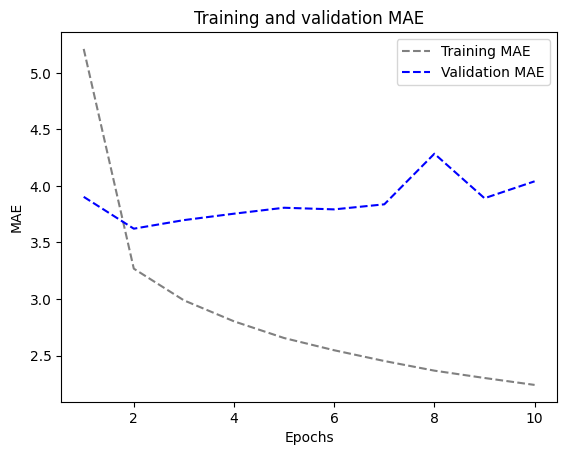

In [49]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


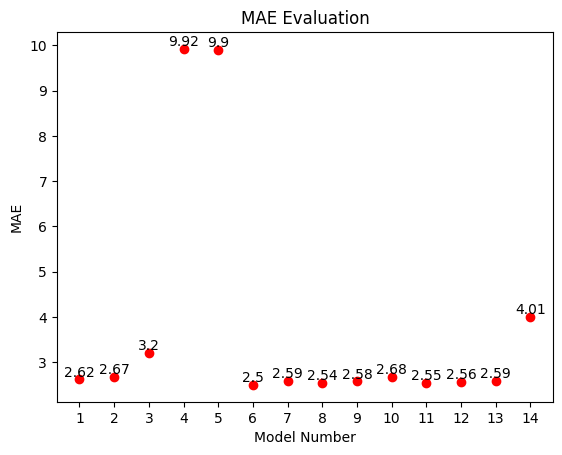

In [50]:
import matplotlib.pyplot as plt

Models = ("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14")
Mae = (2.62, 2.67, 3.2, 9.92, 9.9, 2.5, 2.59, 2.54, 2.58, 2.68, 2.55, 2.56, 2.59, 4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models, Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

For weather time-series forecasting, a comparative analysis of several LSTM-based and hybrid models showed that regularized and simpler architectures (such as bidirectional LSTMs and dropout-regularized LSTMs) outperformed deeper, more sophisticated stacks in terms of generalization and MAE.  By effectively fusing temporal learning and local feature extraction, the Conv1D + LSTM hybrid model also demonstrated competitive performance.  In general, regularization and careful architectural tuning work better than simply making the model more complex.
